CppAD是一个用于自动微分（Automatic Differentiation，AD）的C++库，全称是"Computational Differentiation in C++ using Operator Overloading"。  

自动微分是一种计算导数的技术，它通过计算程序中各个步骤对输入的微分来实现对整个函数的导数计算。  

来源：https://zhuanlan.zhihu.com/p/518198564

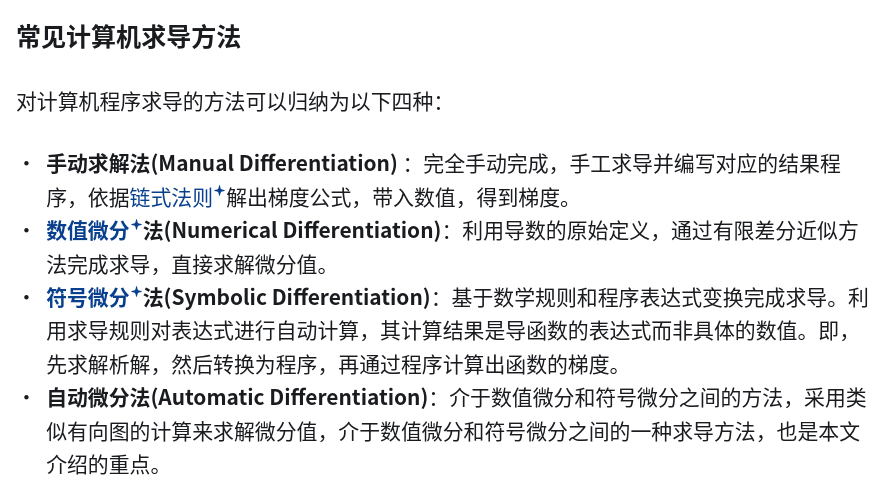  
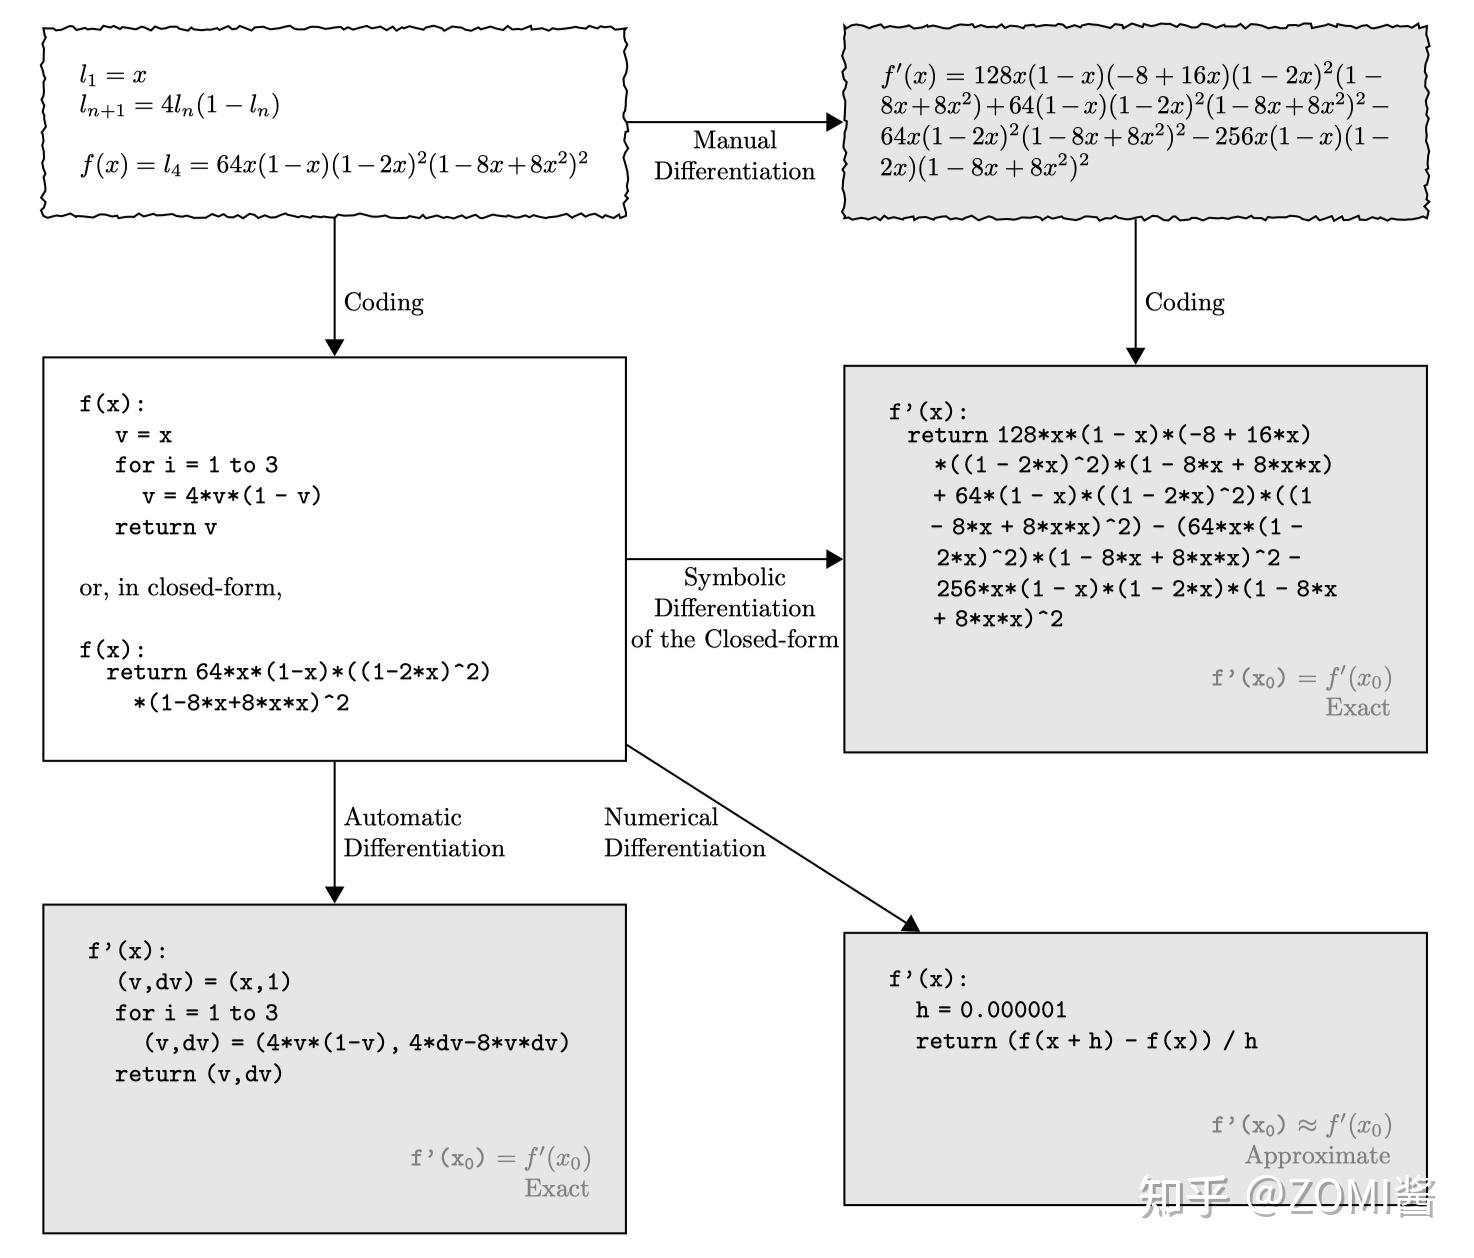  

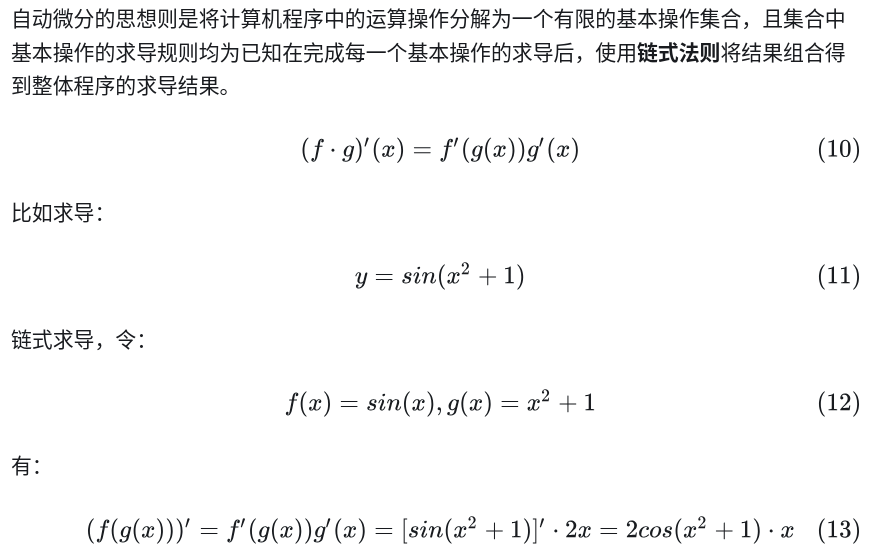  
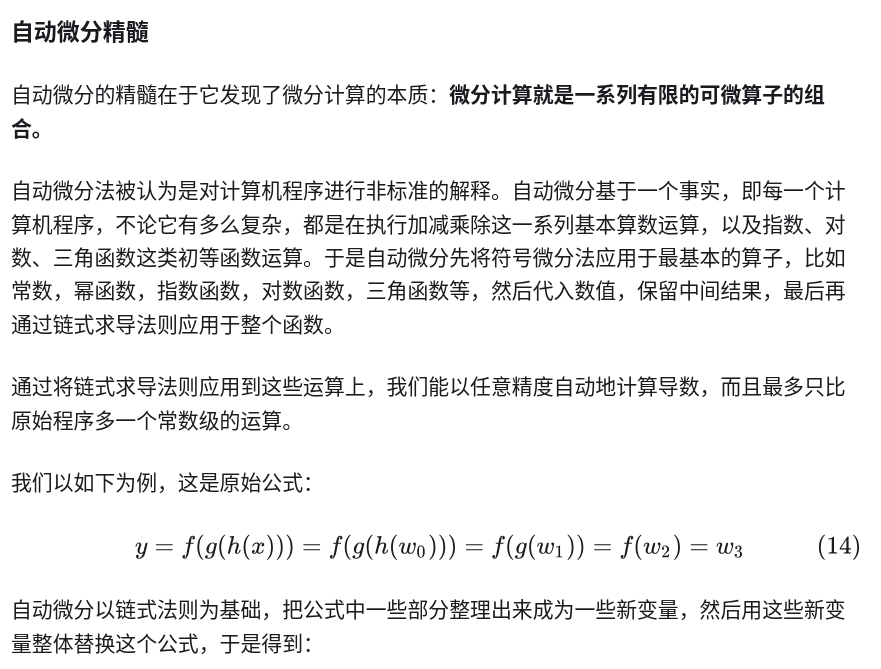  
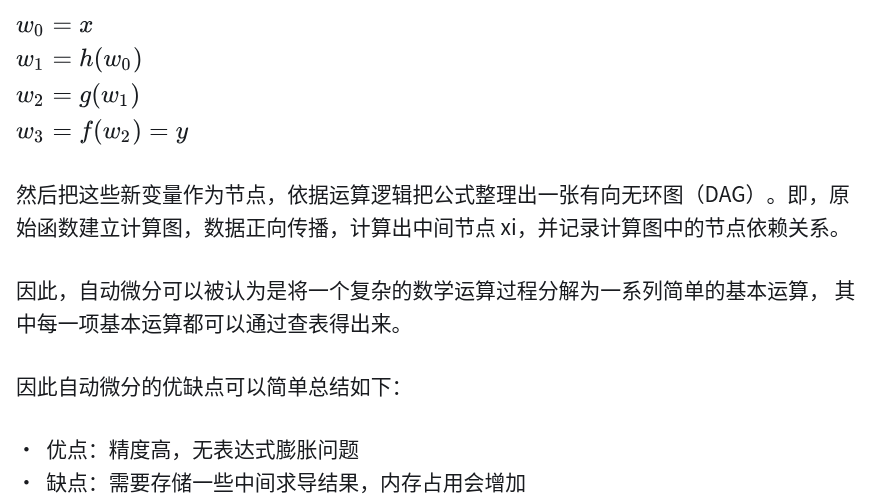

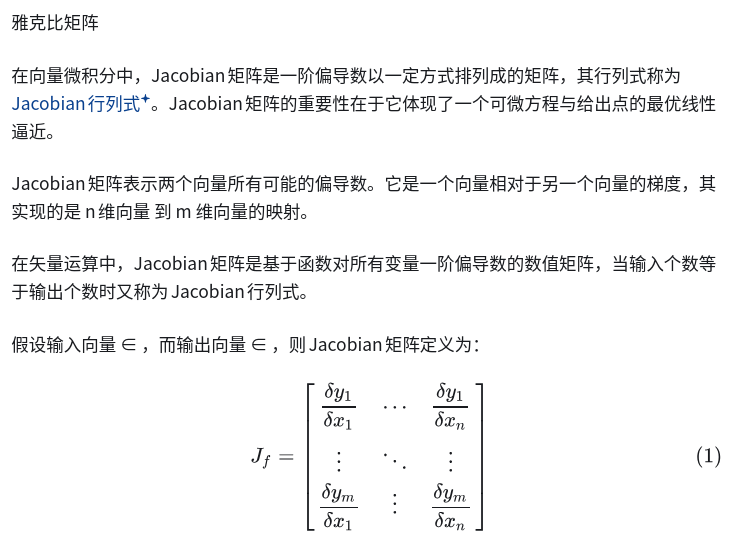

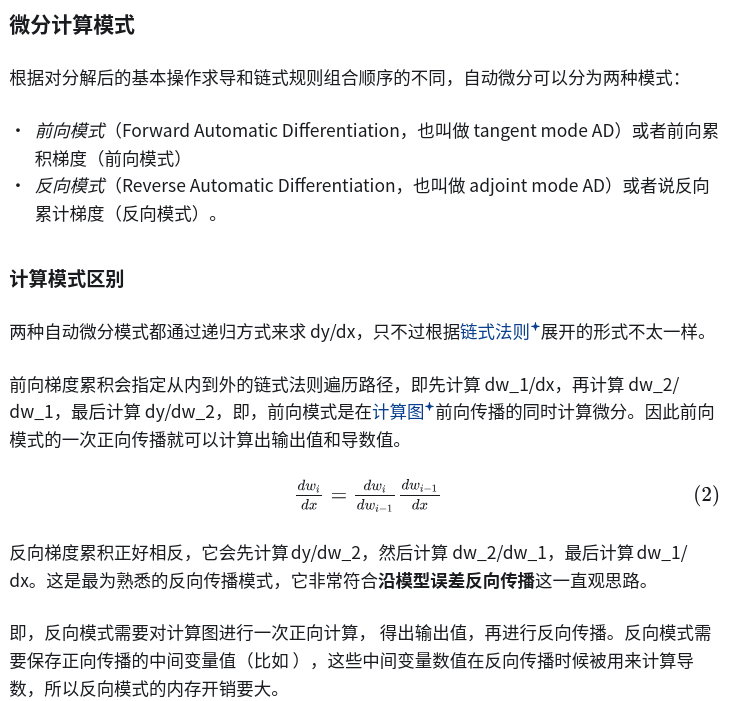

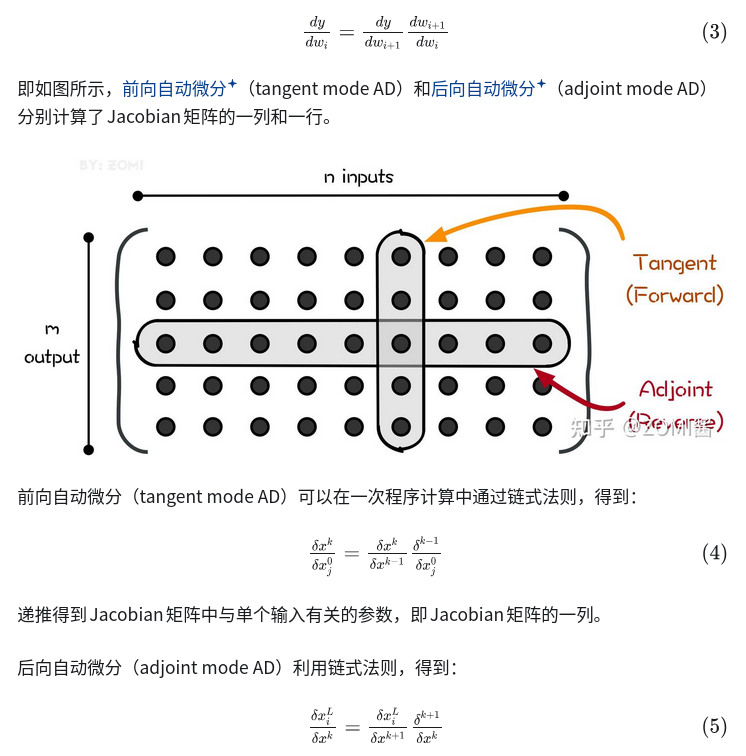

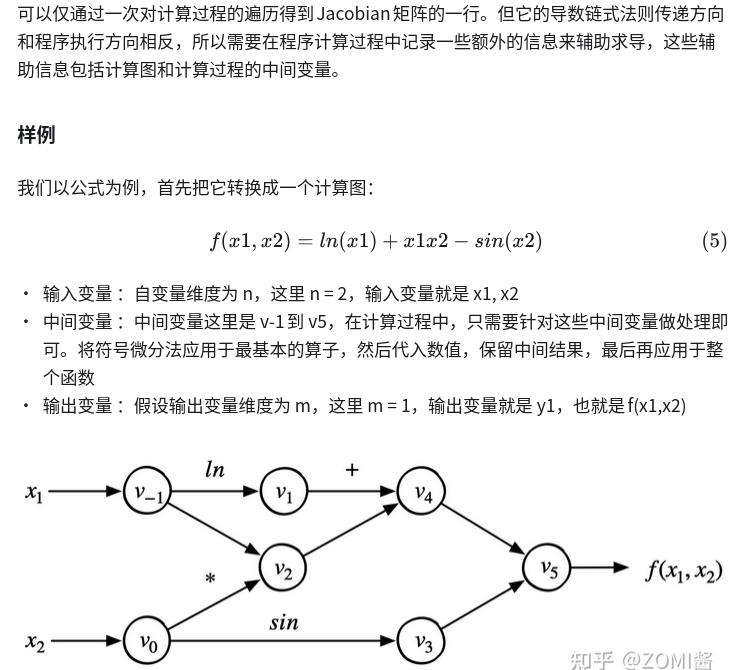

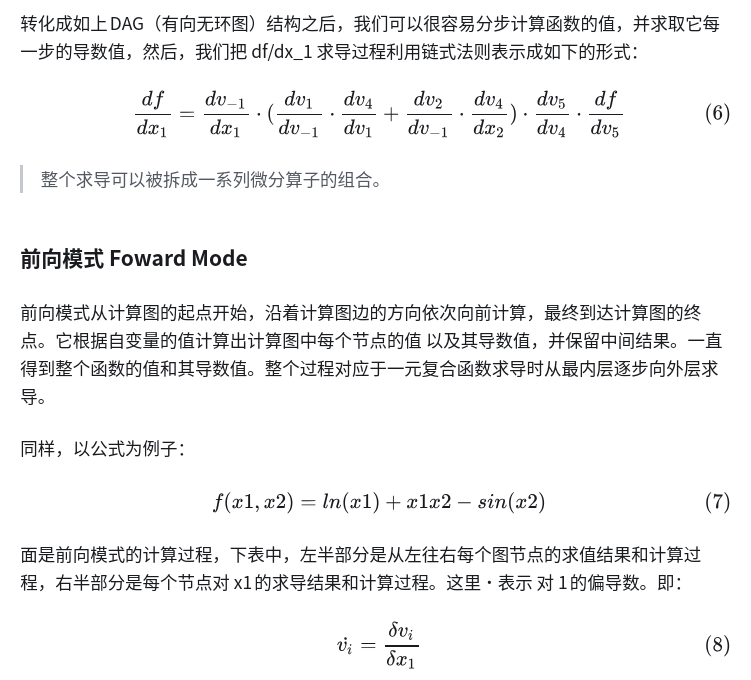

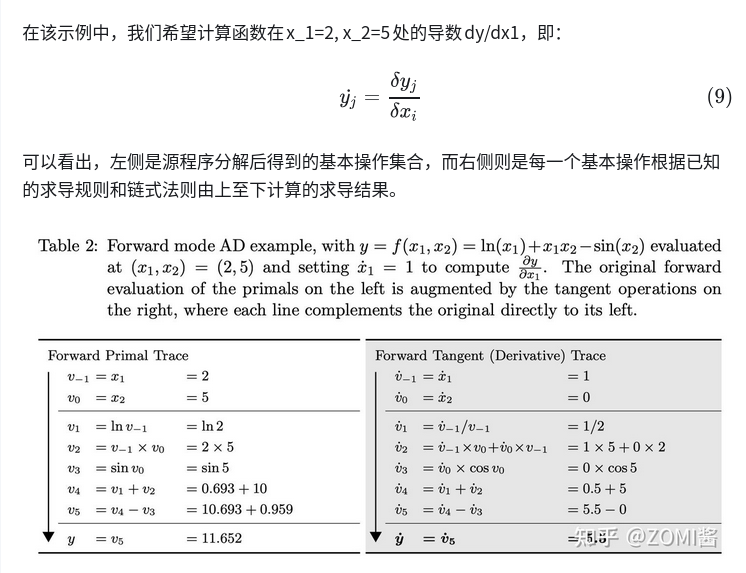

把上述过程当做雅克比矩阵求解问题，假设一个函数有 n 个输入变量 $x_i$，m个输入变量 $y_j$，即输入向量 $x \in R^n, y \in R^m$，则这个的映射是：  
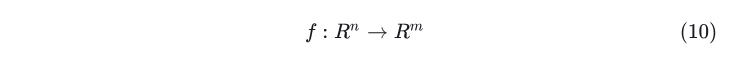  
在这种情况下，每个自动微分的前向传播计算时候，初始输入被设置为 $\dot{x_i}=1$，其余被设置为 0。对应Jacobian矩阵定义为：  
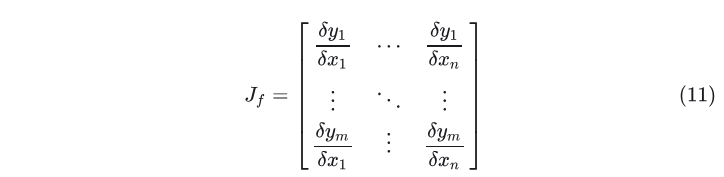  
一次前向计算，可以求出Jacobian矩阵的一列数据，如 $\dot{x_3}=1$ 对应就可以求出来第3列。  
tangent mode AD可以在一次程序计算中，通过链式法则递推得到Jacobian矩阵中与单个输入有关的部分，即Jacobian矩阵的一列。  

如下图所示，如果想用正向模式求对所有输入的导数，需要计算 n 次才能求出所有列。  
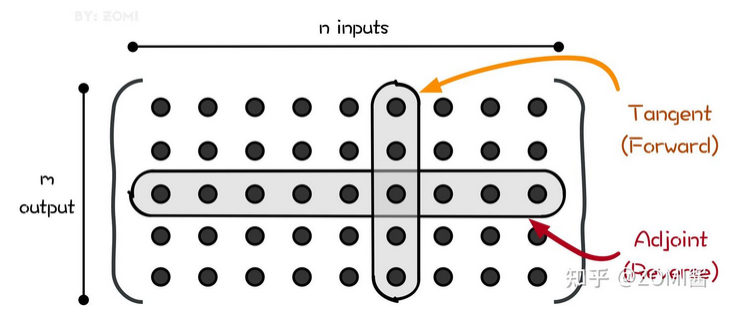

进一步，设置 $\dot{x}=r$，可以在一次前向传播中直接计算 Jacobian–vector 乘积：  
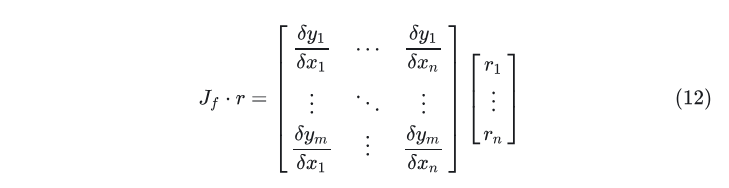  
最终我们可以递归的得到本次迭代的计算目标：雅克比矩阵中的第 i 行  

<pre>优缺点

前向模式的优点：
    实现起来很简单
    也不需要很多额外的内存空间
向前模式的缺点：
    每次前向计算只能计算对一个自变量的偏导数，对于一元函数求导是高效的，但是机器学习模型的自参数（入参）数量级大。
    如果有一个函数，其输入有 n 个，输出有 m个，对于每个输入来说，前向模式都需要遍历计算过程以得到当前输入的导数，求解整个函数梯度需要 n 遍如上计算过程。

<pre>反向模式 Reverse Mode

反向自动微分同样是基于链式法则。仅需要一个前向过程和反向过程，就可以计算所有参数的导数或者梯度。
因为需要结合前向和后向两个过程，因此反向自动微分会使用一个特殊的数据结构，来存储计算过程。
而这个特殊的数据结构例如Tensorflow或者MindSpore，则是把所有的操作以一张图的方式存储下来，这张图可以是一个有向无环（DAG）的计算图；
而Pytroch则是使用Tape来记录每一个操作，他们都表达了函数和变量的关系。
反向模式根据从后向前计算，依次得到对每个中间变量节点的偏导数，直到到达自变量节点处，这样就得到了每个输入的偏导数。
在每个节点处，根据该节点的后续节点（前向传播中的后续节点）计算其导数值。
整个过程对应于多元复合函数求导时从最外层逐步向内侧求导。这样可以有效地把各个节点的梯度计算解耦开，每次只需要关注计算图中当前节点的梯度计算。
从下图可以看出来，reverse mode和forward mode是一对相反过程，reverse mode从最终结果开始求导，利用最终输出对每一个节点进行求导。
下图虚线就是反向模式。<pre>


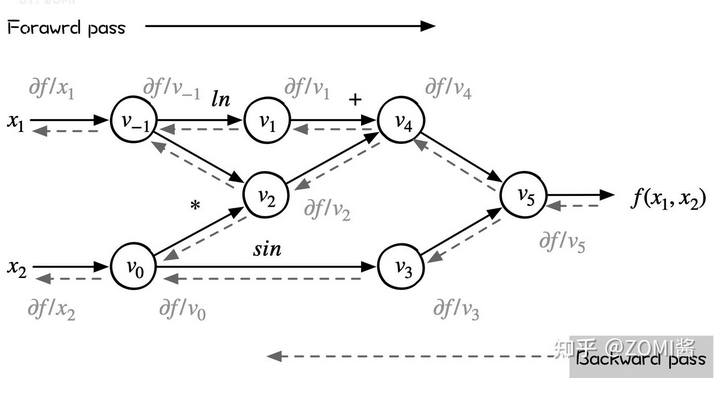

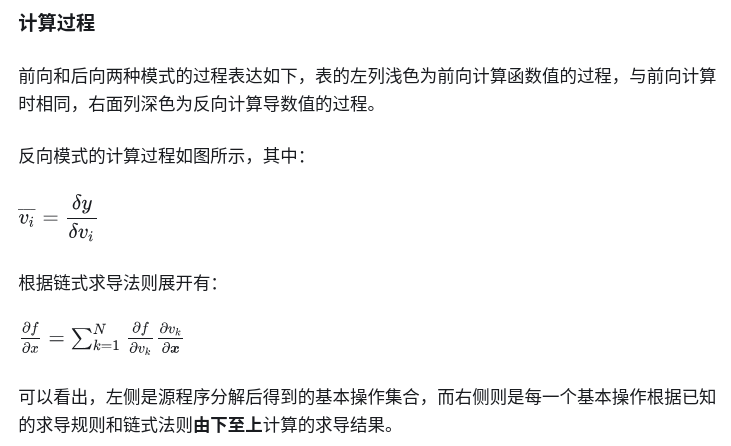  
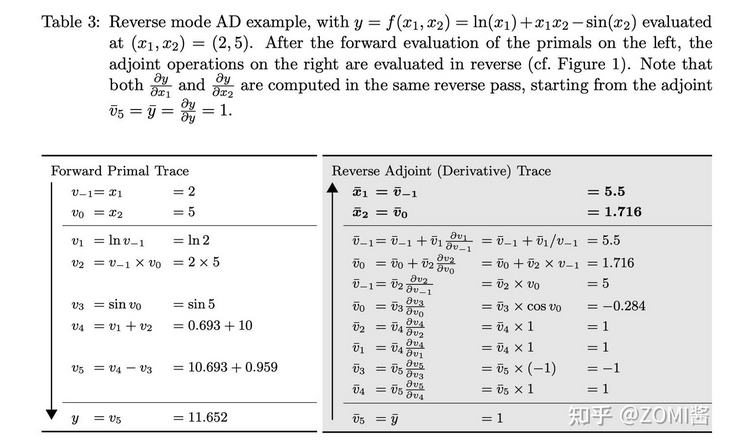

到目前为止，我们已经计算出来了所有步骤的偏导数的数值。现在需要计算 $\overline{v}_1$ 和 $\overline{v}_2$ 。  
计算 $\overline{v}_1$ 从最后的位置往前到自变量 $x_1$，有多条路径，需要将这个路径上的数值连乘起来得到一个乘积数值，然后将这多条路径的乘积数值相加起来得到最后的结果。  

从 y 到 x_1 的路径有两条，分别是：  

$v_5 \to v_4 \to v_1 \to v_{-1}$，其数值乘积是 1∗1∗0.5=0.5  
$v_5 \to v_4 \to v_2 \to v_{-1}$，其数值乘积是 1∗1∗ 5= 5  

因此，$\overline{v}_1=0.5+5=5.5$，同理有 $\overline{v}_2=2.0-0.284=1.716$  

向量-雅克比矩阵

对于函数 $\overline{y}=f(\overline{x})$，其中 $f: \mathbb{R}^{n} \rightarrow \mathbb{R}^{m}$，  
那么 $\overline{y}$ 中关于 $\overline{x}$ 的梯度可以表示为 Jacobian 矩阵：  

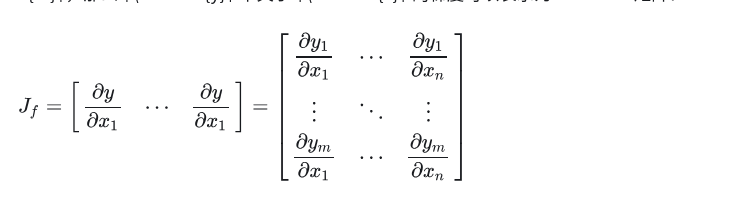  

设置 $\overline{v}$ 是关于函数 $l=g(\overline{y})$ 的梯度：  

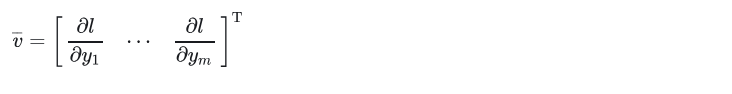  

Jacobian-vector 积就是函数 l 中关于 $x_1$ 的梯度：  

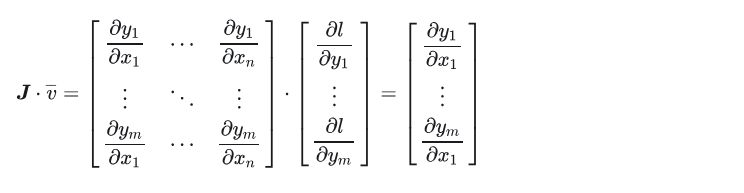  

即通过雅克比矩阵转置与后续节点梯度值的乘积，可以得到当前节点的梯度值。  

<pre>优缺点

前向模式在计算之中，计算图各个节点的数值和该节点的导数可同步求出，但是代价就是对于多个输入需要多次计算才行。
反向模式的优点：
    通过一次反向传输，就计算出所有偏导数，中间的偏导数计算只需计算一次
    减少了重复计算的工作量，在多参数的时候后向自动微分的时间复杂度更低
反向模式的缺点：
    需要额外的数据结构记录正向过程的计算操作，用于反向使用
    带来了大量内存占用，为了减少内存操作，需要深度学习框架进行各种优化，也带来了额外限制和副作用

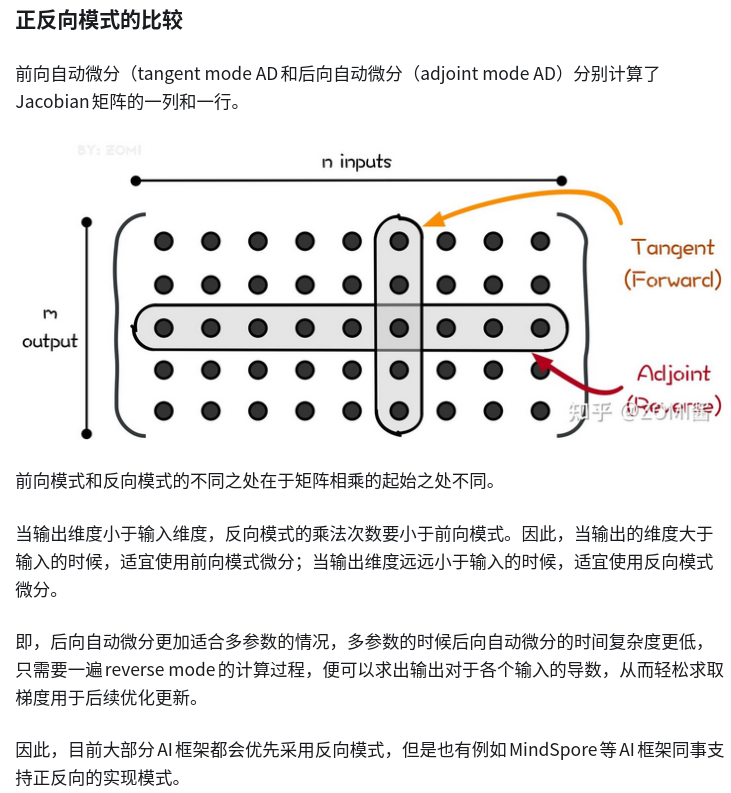  
